## Introduction

In the previous lesson we learned about the [Basemap][1] mapping toolkit for the matplotlib library. We also played around with it a bit to create a simple, aesthetically pleasing map of the world, but aside from being able to see the general location of each country in the world, our map wasn't necessarily packed with information. 

In this lesson, we'll use the basemap toolkit to create a chorlopleth map. 

A [choropleth][2] is a [thematic map][3] in which areas are shaded, patterned, or colored to represent some underlying value associated with a particular phenomenon. The specific phenomenon we'll be studying is unemployment. Specifically, we'll be looking at the unemployment rate per county in the US before, during, and after the [Great Recession][4].

Let's not waste anymore time talking about the task at hand, let's dive right in and get set up.

[1]: http://matplotlib.org/basemap/
[2]: https://en.wikipedia.org/wiki/Choropleth_map
[3]: https://en.wikipedia.org/wiki/Thematic_map
[4]: https://en.wikipedia.org/wiki/Great_Recession_in_the_United_States

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# The current version of NumPy available from conda is issuing a warning 
# message that some behavior will change in the future when used with the 
# current version of matplotlib available from conda. This cell just keeps
# that warning from being displayed.
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Loading the Unemployment Data

Just as we did in our earlier lessons, in this lesson, we'll be making use of `namedtuple`s to wrap each unemployment record in the data making it easier to work with throughout the rest of the lesson. 

The code below creates the `UnemploymentRecord` data structure with the `namedtuple` function. Of the fields passed into the `namedtuple` function, the two that we are the most interested in, are the FIPS code and the unemployment rate. A [FIPS code][1] is a five-digit number that uniquely identifies each county in the US, and we'll be using it to match up the unemployment rates to the county objects in the shapefile that we'll read in later. This will allow us to color each county in the map according to its unemployment rate.

[1]: https://en.wikipedia.org/wiki/FIPS_county_code

In [2]:
from collections import namedtuple

UnemploymentRecord = namedtuple('UnemploymentRecord', ('laus_code', 
                                                       'fips_code', 
                                                       'name', 
                                                       'year',
                                                       'labor_force',
                                                       'employed',
                                                       'unemployment_level',
                                                       'unemployment_rate'))

Now that we have a data structure for each unemployment record, we're ready to read in the data. Since we're going to be loading data from multiple years, it makes sense to create a function for doing this task, so we don't end up copying and pasting the code into multiple places. 

The code below creates a function called `load_unemployment_rates` that takes one parameter, a year as an integer value, downloads the data for the given year, and returns a list of `UnemploymentRecord` objects. 

The data that we'll be using comes from the [Bureau of Labor Statistics][1]. Specifically, we'll be using the [county unemployment data][2] in the Excel format. The data's also available in a text format, but it isn't in a machine-friendly format such as a comma, or tab delimited format, but thankfully, the fantastic [xlrd][3] library is available as a conda install, and it makes it very convenient to read in the data from an Excel file. Given this requirement, before you can run the code in the `load_unemployment_rates` function below, you'll need to do a quick `conda install xlrd` to install the required package.

[1]: http://www.bls.gov/
[2]: http://www.bls.gov/lau/#cntyaa
[3]: http://www.python-excel.org/

In [3]:
import urllib2
import xlrd

# The URL for the Labor Force Data by County, or Local Area 
# Unemployment Statistics (LAUS), from the Bureau of Labor Statistics
#base_url = "http://www.bls.gov/lau/laucnty%02d.xlsx"

# The following code pulls the local data files in instead of downloading them on the fly
import os
base_url = "file://%s/data/laucnty%%02d.xlsx" % os.getcwd()

def load_unemployment_rates(year):
    """Loads the unemployment data for the given year from the BLS.
    
    Arguments:
    year -- The year (as an int) to load unemployment data for
    """
    url = base_url % (year - 2000)
    response = urllib2.urlopen(url)
    workbook = xlrd.open_workbook(file_contents=response.read())
    sheet = workbook.sheet_by_index(0)
    
    data = []
    for i in range(6, sheet.nrows-4):
        row = sheet.row_values(i)
        data.append(UnemploymentRecord(
            laus_code           = row[0],
            fips_code           = row[1] + row[2],
            name                = row[3],
            year                = int(row[4]),
            # For some reason, they have an extra, empty column here
            labor_force         = int(row[6]) if row[6] != 'N.A.' else 0,
            employed            = int(row[7]) if row[7] != 'N.A.' else 0, 
            unemployment_level  = int(row[8]) if row[8] != 'N.A.' else 0,
            unemployment_rate   = float(row[9]) if row[9] != 'N.A.' else 0.))
        
    return data

The code for the `load_unemployment_rates` function is really quite straightforward. We simply download the data for the given year, parse it with the xlrd library, and wrap each row's data in an `UnemploymentRecord` tuple. The only bit of preprocessing that we need to do on the data can be seen on lines 24 and 26-31. On line 24, we concatenate the state and county FIPS codes into a single FIPS code string, and on lines 26-31 we cast some of the data, e.g., the unemployment rate, into `int`s and `float`s. We have to be a bit careful when doing this though since, in some records, we can get an `'N.A.'` for the value. In those cases, we simply set the value to 0. 

## Create a Color Mapper

Alright, so now we have a function for loading in the unemployment data, next we'll need a way to map each unemployment rate to a color. Personally, I prefer as simple an interface as possible, e.g., I'd like to just call a function with a value and get back a color. Unfortunately, we just can't grab a color map from matplotlib and pass in an unemployment rate. The problem with doing so is that a color map expects a float between 0 and 1 and our data ranges from roughly 2-30, thus every value in our data falls outside of the range of the color map, and so we end up with a map where every county is "painted" black. 

A color map also supports passing in an integer value, and it maps that value to one of 256 colors in the map. Given this option, we could simply call `int` on each value before passing it into the color map, but unfortunately, this creates another problem. Since our data consists of values between 2 and 30, all of our values are on the low end of the spectrum when compared to the color map's range of 0-255. With this method, we would end up with an extremely "watered down" map where all of the counties look a nearly identical shade of pale yellow.

The solution to both of these problems is to normalize each unemployment rate before passing it into our color map. Fortunately, matplotlib provides the `pyplot.Normalize` class to make doing so extremely easy. But, as I mentioned before, we want a simple interface that allows us to pass in a value and get a color, and we don't want to normalize each value before doing so. One way to accomplish this is through a callable object that encapsulates the creation of the normalization function for our data, as well as its application on each individual value. Again matplotlib provides what we need to make this really easy. The `pyplot.cm.ScalarMappable` class is a mixin class for adding color map functionality to custom classes. In the code snippet below, we use this class to create our `HeatMapper` helper class.

In [4]:
class HeatMapper(plt.cm.ScalarMappable):
    """A callable that maps cold colors to low values, and hot to high.
    """
    def __init__(self, data=None):
        norm = plt.Normalize(vmin=min(data), vmax=max(data))
        cmap = plt.cm.hot_r
        super(HeatMapper, self).__init__(norm, cmap)
        
    def __call__(self, value):
        return self.to_rgba(value)

Our `HeatMapper` class is very simple since it inherits from the `plt.cm.ScalarMappable` class that takes on the brunt of the hard work for us. All we have to do is create the normalize function from the data that's passed into the constructor. Then, we implement the callable interface by overriding the `__call__` method to return the result from calling `ScalarMappable`'s  `.to_rgba` function.

## Drawing the Choropleth

In this section we'll create a function that will draw the choropleth for a given set of unemployment rates. One of the things we'll need to create our `draw_choropleth` function, is a list of FIPS codes for all 48 contiguous states since we don't want to draw the counties for any of the states outside of the contiguous United States.

In [5]:
# List of the FIPS codes for the 48 contiguous states 
# source: http://www.bls.gov/cew/cewedr10.htm)
contiguous_states_fips = [
    '01',   # Alabama 
    '04',   # Arizona 
    '05',   # Arkansas    
    '06',   # California  
    '08',   # Colorado    
    '09',   # Connecticut 
    '10',   # Delaware    
    '11',   # District of Columbia    
    '12',   # Florida 
    '13',   # Georgia 
    '16',   # Idaho   
    '17',   # Illinois    
    '18',   # Indiana 
    '19',   # Iowa    
    '20',   # Kansas  
    '21',   # Kentucky    
    '22',   # Louisiana   
    '23',   # Maine   
    '24',   # Maryland    
    '25',   # Massachusetts   
    '26',   # Michigan    
    '27',   # Minnesota   
    '28',   # Mississippi 
    '29',   # Missouri    
    '30',   # Montana 
    '31',   # Nebraska    
    '32',   # Nevada  
    '33',   # New Hampshire   
    '34',   # New Jersey  
    '35',   # New Mexico  
    '36',   # New York    
    '37',   # North Carolina  
    '38',   # North Dakota    
    '39',   # Ohio    
    '40',   # Oklahoma    
    '41',   # Oregon  
    '42',   # Pennsylvania    
    '44',   # Rhode Island    
    '45',   # South Carolina  
    '46',   # South Dakota    
    '47',   # Tennessee   
    '48',   # Texas   
    '49',   # Utah    
    '50',   # Vermont 
    '51',   # Virginia    
    '53',   # Washington  
    '54',   # West Virginia   
    '55',   # Wisconsin   
    '56',   # Wyoming 
]

Our `draw_choropleth` function takes 3 parameters: a `Basemap` class instance, a list of `UnemploymentRecord` tuples, and a callable that maps unemployment rates to colors.

The code for our drawing function itself is relatively simple since it assumes that the Basemap object is completely setup at the time it's passed in. By "completely setup", I mean that the shapefile for the counties has already been loaded into the `Basemap` object, so we can simply loop through each of the counties in the map and draw each one with its associated color. To draw a county on our map, we create an instance of the `Polygon` class, with a county's coordinates, and pass it into the `Axes.add_patch` function, which we can see happening on line 27 below. 

So, the major portion of the code below, specifically lines 17-27, is just a big loop, where for each county in the map, we get a color for its unemployment rate, draw a polygon with the county's coordinates, fill it with the corresponding color, and add it to our map. This will give the map that familiar patchwork look of a choropleth.

In [6]:
from mpl_toolkits.basemap import Polygon

def draw_choropleth(m, data, color):
    """Draws a choropleth.
    
    Arguments:
    m -- The map projection
    data -- The unemployment data
    color -- A function that takes an unemployment rate and returns 
             a hex value representing a color.
    """
    # Convert the unemployment data into a dict mapping FIPS codes to unemployment_rates
    unemployment_rates = {r.fips_code: r.unemployment_rate for r in data}
    
    # Draw all of the counties to the current axes
    ax = plt.gca()
    for info, shape in zip(m.counties_info, m.counties):
        # We're only showing unemployment rates for the 48 contiguous states, 
        # so skip anything that doesn't show up in the list.
        if info['STATEFP'] not in contiguous_states_fips:
            continue
        try:
            fips = info['STATEFP'] + info['COUNTYFP']
            unemployment_rate = unemployment_rates[fips]
        except KeyError:
            continue
        ax.add_patch(Polygon(np.array(shape), facecolor=color(unemployment_rate), 
                             edgecolor='#221e1f', linewidth=0.5))    

    # Calling drawmapboundary will ensure that the x- and y-axis 
    # limits are set correctly for the map and draws either simple 
    # border (or no border as in our example below) in place of a 
    # typical x- and y-axis with tick marks.
    m.drawmapboundary(color='none');

## Create the Map Object

The next bit of code creates our `Basemap` instance. In the last lesson, we used the Robinson projection, which is great for showing a map of the world, but it distorts both the shape and size of the land masses closer to the poles. For this lesson, we'll use the [Lambert Conformal Conic][1] projection, which should show us a more accurate portrayal of the United States since it does a better job of preserving the shape of the continents.

To use this projection, we have to pass in the lat/lon coordinates for the region of the map that we want to draw. We can get that information from Google Maps by simply ctrl-clicking (right clicking) on a point on the map, and choosing the "What's here?" option. 

Next, we need either 1 or 2 lines of latitude for the standard parallels. These are used by the projection to adjust where the largest amounts of distortion in the map arise, and the closer these are to the area that you want to display, the smaller the amount of distortion. We're going to use the coordinates for the [geographic center of the United States][2] to limit the distortion as much as possible. 

Finally, we need to choose the line of longitude for the center of the map, and again we'll use the geographic center of the US here as well.

[1]: https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection
[2]: https://en.wikipedia.org/wiki/Geographic_center_of_the_United_States

In [7]:
from mpl_toolkits.basemap import Basemap

# Lambert Conformal map of lower 48 states.
m = Basemap(
    # These four attributes define the bounding box, 
    # i.e., the area of the world that we want to show 
    # in our map.
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    # We've chosen the Lambert Conformal Conic projection. 
    projection='lcc',
    # These two params define the 1st (and 2nd) standard parallel
    # and the central meridian used by the projection.
    lat_1=39,
    lon_0=-98
   )

## Load the Counties Shapefile

While `Basemap` instances have methods for drawing things like lakes and rivers, coastlines, and political boundaries, they don't have anything for drawing the boundaries of the counties of the US built in. `Basemap` instances do, however, have the ability to read in a [shapefile][1] to make it possible to draw the county boundaries ourselves. 

The next line of code reads in the [counties shapefile][2] from the United States Census website, which I've already downloaded and included in the repository to make things a tad bit easier.

[1]: https://en.wikipedia.org/wiki/Shapefile
[2]: https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html

In [8]:
# Set drawbounds to False to make sure the map isn't drawn in this step
m.readshapefile('./shapefiles/cb_2014_us_county_500k_2d/cb_2014_us_county_500k', 'counties', 
                drawbounds=False);

## The Great Recession

Well, helper functions written and shapefiles read in, we're finally ready to explore the data. The next little bit of code loads in three years of unemployment data and draws a choropleth map for each one. The years that we show are 2006 (the year right before the Great Recession), 2009 (the recession at its peak), and 2014 (the latest year for which we have census data). 

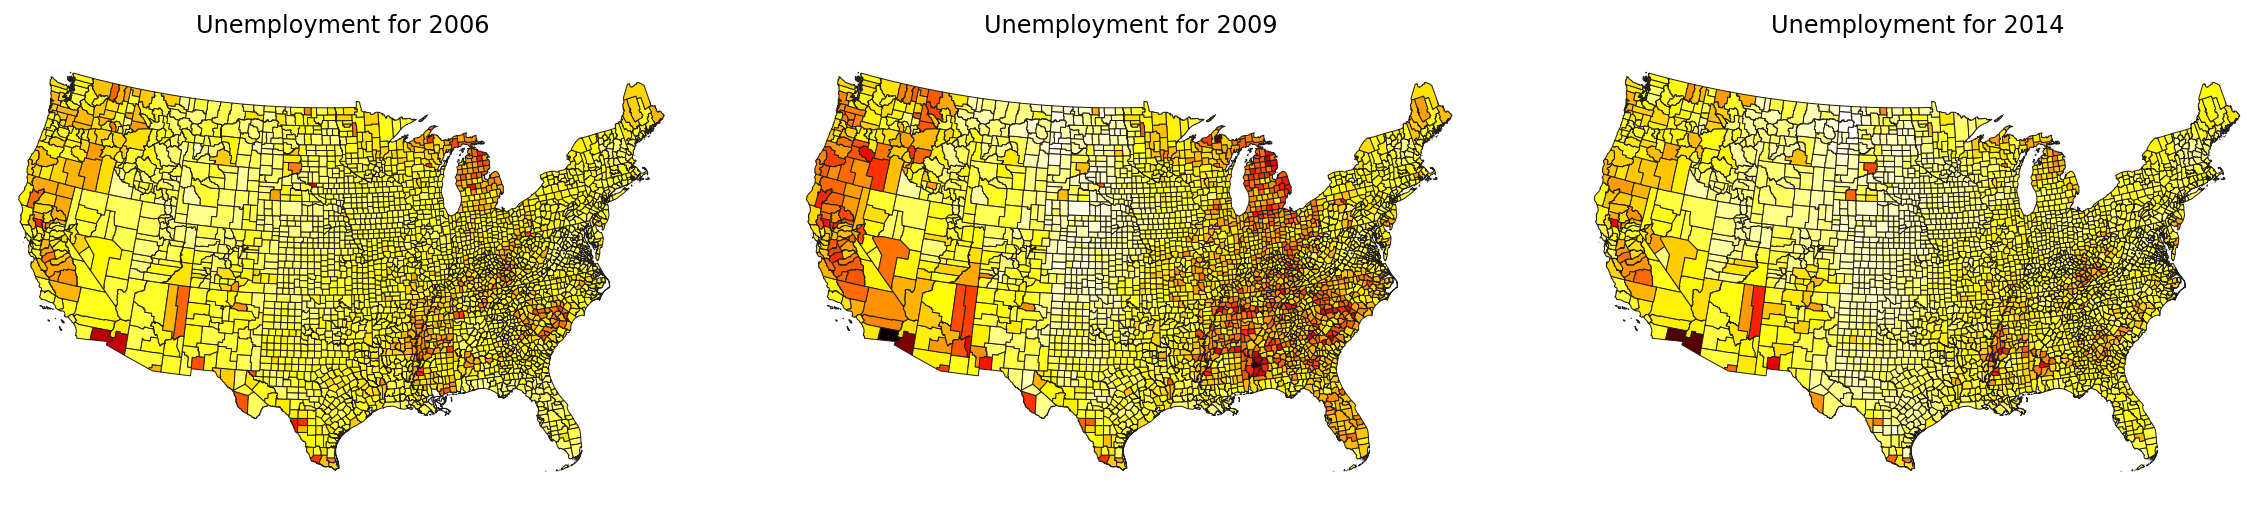

In [9]:
# The Great Recession began in 2007 and hit its peak in 2009. 
# We'll look at the unemployment rate, before it began, at its
# peak, and finally the most recent year that we have data for.
years = [2006, 2009, 2014]

plt.figure(figsize=(20, 10))
for i, year in enumerate(years):

    # Get the data from the file
    data = load_unemployment_rates(year)
    color = HeatMapper([r.unemployment_rate for r in data])

    # Create a new subplot and add a title
    plt.subplot(1, len(years), i+1)
    plt.title('Unemployment for %s' % year)
    
    # Draw the map
    draw_choropleth(m, data, color)

Looking at the maps above, it's easy to see the damage that the recession did to the country's employment rate. 2006 shows unemployment rates to be fairly low across nearly all of the states, with slightly higher unemployment rates on the west cost and the southeast. In the 2009 map, on the other hand, we see the west coast and the southeast really heat up as unemployment rates reach their peak. It also looks like Michigan's employment rate took a bit hit during the recession as well, which makes sense since saw such a steep decline in manufacturing jobs across the US. Finally, in the 2014 map, we can see that the country as a whole has made a complete recovery, and in some cases, the midwest in particular, we even see a decrease in unemployment rates compared to the pre-recession map of 2006.

## The Peak of the Recession

Lastly, just to get a better view of the peak of the recession, and to show off just how good our choropleth's look, we blow up the 2009 map in the code below.

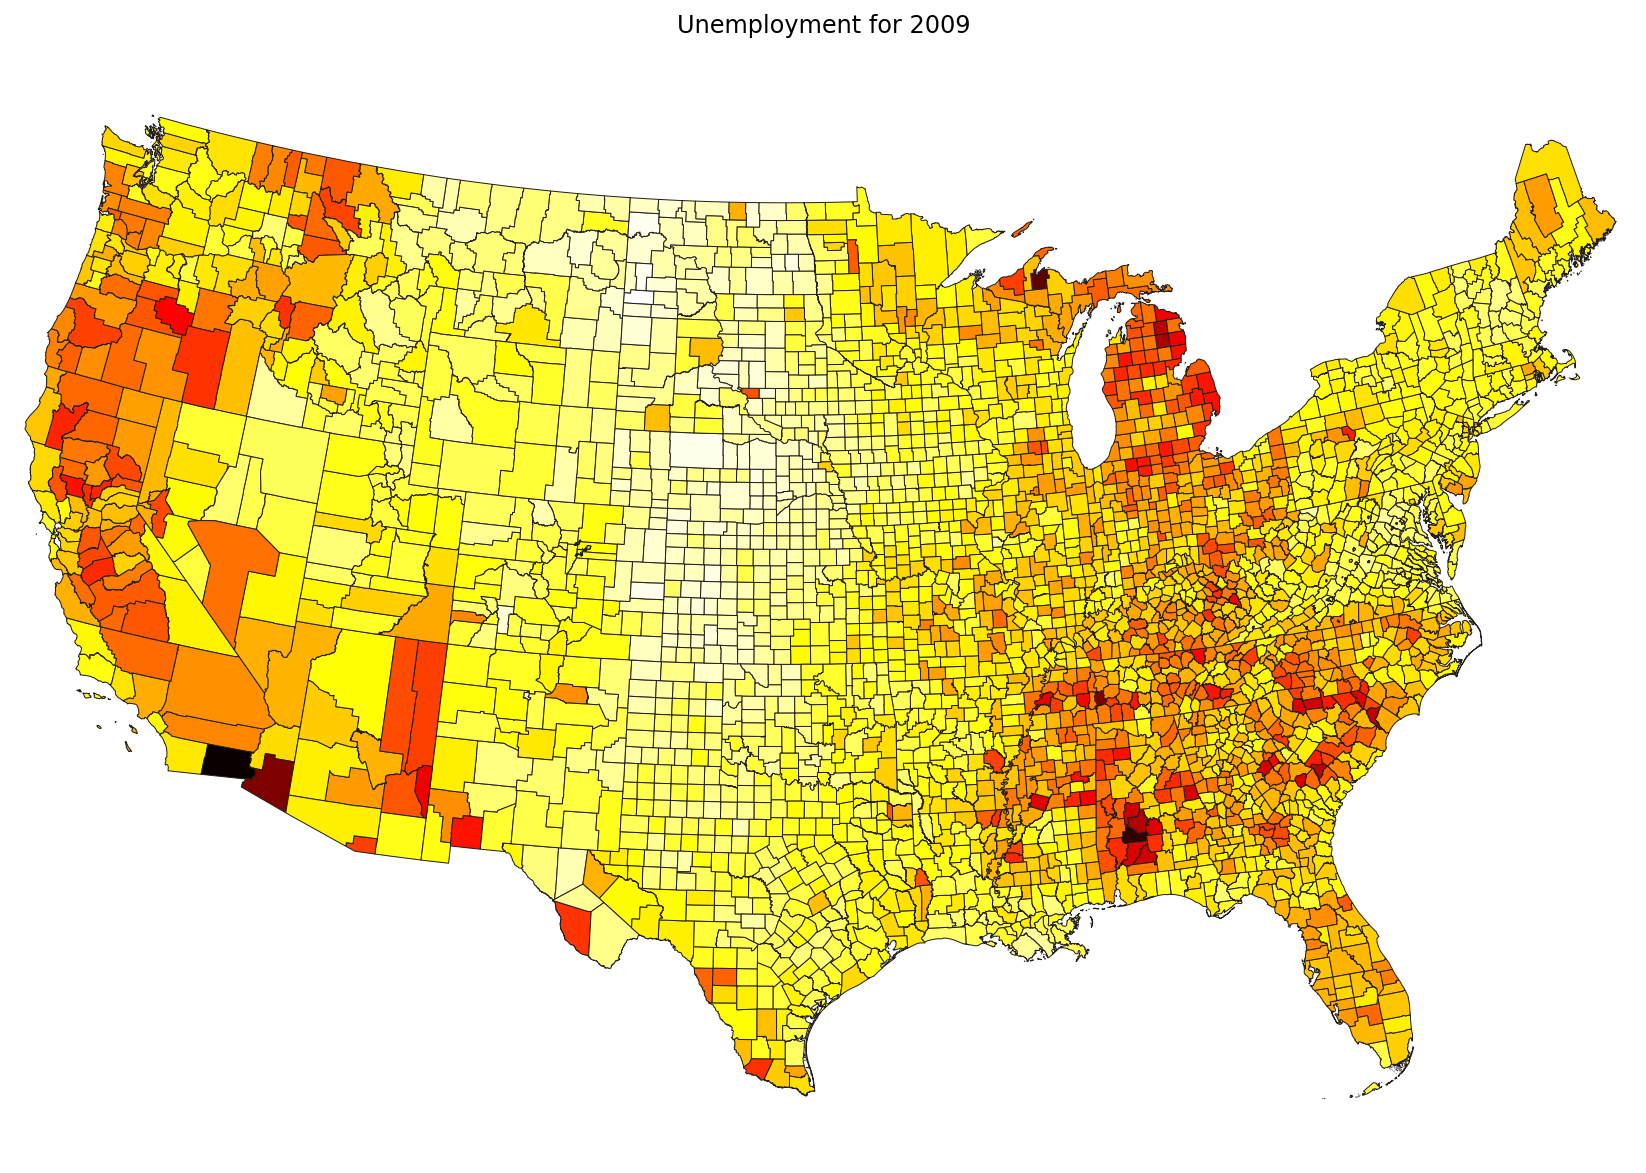

In [10]:
plt.figure(figsize=(20,10))
plt.title("Unemployment for 2009")
data = load_unemployment_rates(2009)
color = HeatMapper([r.unemployment_rate for r in data])
draw_choropleth(m, data, color)

## Conclusion

In prior lessons, we first learned about map projections in general, and then we saw how to use the basemap library to create our own maps. In this lesson, we took our knowledge of the basemap library a bit further by using it to create a choropleth map that visualized the unemployment data in the US. Mapping data like this has a very distinct advantage over other visualization techniques, since it allows us to quickly see where, and to what extent, a particular phenomenon has on a particular geographic area of the population.

In the next, and final basemap lesson, we'll see yet another example of just how useful the basemap library can be by mapping local crime data using maps from an ArcGIS online service.